# Cross-lingual Semantic Textual Similarity

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import numpy as np

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSeq2SeqLM
from datasets import load_dataset

from util import encode_batch

In [4]:
# 1- load the model the tokenizer
hf_model_id = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(hf_model_id)
model = AutoModel.from_pretrained(hf_model_id)

model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [5]:
langs = ['en', 'de', 'es', 'fr', 'it', 'nl', 'pl', 'pt', 'ru', 'zh']

In [6]:
datasets = {}
for l in langs:
    datasets[l] = load_dataset("stsb_multi_mt", name=l, split="dev")

Reusing dataset stsb_multi_mt (/gpfs/space/home/maksym95/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/gpfs/space/home/maksym95/.cache/huggingface/datasets/stsb_multi_mt/de/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/gpfs/space/home/maksym95/.cache/huggingface/datasets/stsb_multi_mt/es/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/gpfs/space/home/maksym95/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/gpfs/space/home/maksym95/.cache/huggingface/datasets/stsb_multi_mt/it/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/gpfs/space/home/maksym95/.cache/huggingface/datasets/stsb_multi_mt/nl/1.0.0/a5d260e4b7aa82d1ab7379

In [8]:
en_pivot = datasets['en'].map(function=encode_batch, fn_kwargs={'field': 'sentence1', 'tokenizer': tokenizer, 'model': model},
                              batched=True,
                              batch_size=3000)

for l in langs:
    datasets[l] = datasets[l].map(function=encode_batch, 
                                  fn_kwargs={'field': 'sentence2', 'tokenizer': tokenizer, 'model': model},
                                  batched=True,
                                  batch_size=3000)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [9]:
from ecco import analysis
from scipy import spatial, stats


In [86]:
y_gold = [s / 5. for s in en_pivot['similarity_score']]

In [87]:
num_layers = 13

def sts_spearman(reps1, reps2):
    res = []
    for s, t in zip(reps1, reps2):
        res.append(1 - spatial.distance.cosine(s, t))
    return stats.spearmanr(res, y_gold).correlation, res

In [88]:
from collections import defaultdict

In [89]:
%%time

cls_spearman = defaultdict(list)
mean_spearman = defaultdict(list)

cls_cos = defaultdict(list)
mean_cos = defaultdict(list)


for l in langs:
    print(l)
    for j in range(num_layers):
        corr, cos = sts_spearman(en_pivot[f'cls_{j}'], datasets[l][f'cls_{j}'])
        cls_spearman[l].append(corr)
        cls_cos[l].append(cos)
        
        corr, cos = sts_spearman(en_pivot[f'mean_{j}'], datasets[l][f'mean_{j}'])
        mean_spearman[l].append(corr)
        mean_cos[l].append(cos)
        

en


/gpfs/space/home/maksym95/.conda/envs/paper3/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


de
es
fr
it
nl
pl
pt
ru
zh
CPU times: user 5min 3s, sys: 2.59 s, total: 5min 5s
Wall time: 5min 5s


### Plot correlation with English

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

(0.0, 0.8)

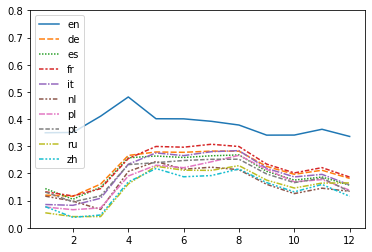

In [91]:
sns.lineplot(data=pd.DataFrame(cls_spearman))
plt.ylim(0, 0.8)

(0.0, 0.8)

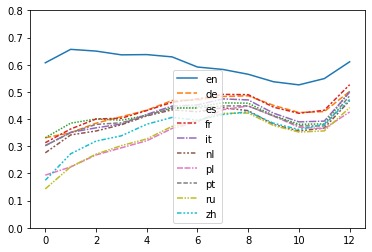

In [92]:
sns.lineplot(data=pd.DataFrame(mean_spearman))
plt.ylim(0, 0.8)

In [93]:
df_mean_spearman = pd.DataFrame(mean_spearman)
df_cls_spearman = pd.DataFrame(cls_spearman)

In [94]:
df_cls_spearman["cl avg"] = df_cls_spearman.loc[:, df_cls_spearman.columns != 'en'].mean(axis=1)
df_mean_spearman["cl avg"] = df_mean_spearman.loc[:, df_mean_spearman.columns != 'en'].mean(axis=1)

In [95]:
xling = {"xling_cls": df_cls_spearman["cl avg"], "xling_mean": df_mean_spearman["cl avg"]}
en = {"en_cls": df_cls_spearman["en"], "en_mean": df_mean_spearman["en"]}

<AxesSubplot:>

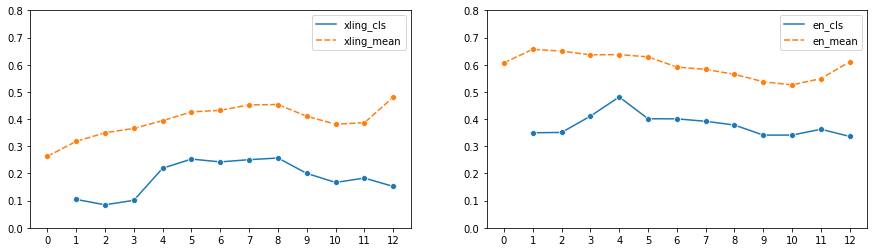

In [96]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

ax[0].set_ylim([0,0.8])
ax[0].set(xticks=list(range(13)))

ax[1].set_ylim([0,0.8])
ax[1].set(xticks=list(range(13)))

sns.lineplot(data=pd.DataFrame(xling), ax=ax[0], marker='o')
sns.lineplot(data=pd.DataFrame(en), ax=ax[1], marker='o')


### Plot cosine similarity

In [ ]:
00 01 02 03 10 11 12 13 20 21 22 23
0  1  2  3  4  5  6  7  8  9  10 11

In [126]:
y_gold = [s / 5. for s in en_pivot['similarity_score']]

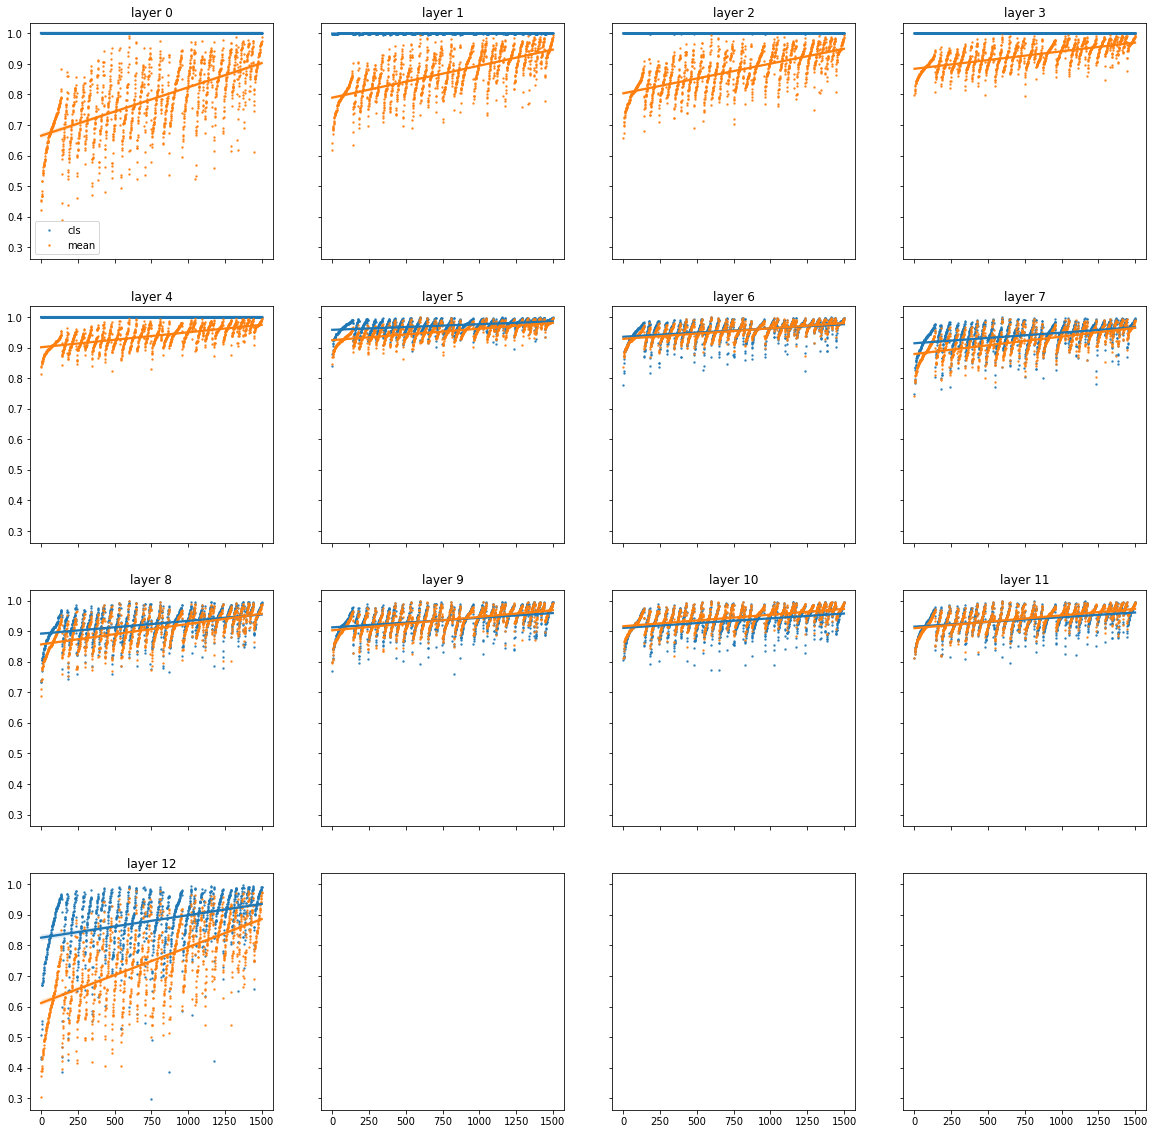

In [131]:
fig, ax = plt.subplots(4,4, figsize=(20,20), sharex=True, sharey=True)

lang='en'

for i in range(4):
    for j in range(4):
        layer = i*4 + j
        
        if layer > 12:
            break
            
        ax[i,j].set_title(f"layer {layer}")

#         sns.regplot(x=list(range(1500)),
#                     y=sorted(y_gold),
#                     scatter_kws={'s':2},
#                     ax=ax[i,j],
#                     label="gold")

        sns.regplot(x=list(range(1500)),
                    y=[x for y, x in sorted(zip(y_gold, cls_cos[lang][layer]))],
                    scatter_kws={'s':2},
                    ax=ax[i,j],
                    label="cls")

        sns.regplot(x=list(range(1500)), 
                    y=[x for y, x in sorted(zip(y_gold, mean_cos[lang][layer]))], 
                    scatter_kws={'s':2},
                    ax=ax[i,j],
                    label="mean")
        
        if layer == 0:
            ax[i,j].legend()

<AxesSubplot:>

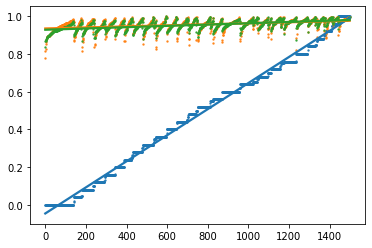

In [118]:
lang='en'
layer=6
sns.regplot(x=list(range(1500)),
            y=sorted(y_gold),
            scatter_kws={'s':2})

sns.regplot(x=list(range(1500)),
            y=[x for y, x in sorted(zip(y_gold, cls_cos[lang][layer]))],
            scatter_kws={'s':2})

sns.regplot(x=list(range(1500)), 
            y=[x for y, x in sorted(zip(y_gold, mean_cos[lang][layer]))], 
            scatter_kws={'s':2})

In [44]:
len(y_gold)

1500

In [47]:
len(mean_cos['en'][0])

1500

In [34]:
print(mean_cos['it'][1])

[0.6903365218358066, 0.7370526770969994, 0.7187636628707103, 0.7697574406927116, 0.7062040594465442, 0.707085625892723, 0.6684579551889147, 0.7034609225002452, 0.7177972065282662, 0.7280633820440584, 0.737253877277632, 0.6970469781491856, 0.6732221982504983, 0.7236727889472202, 0.7339598459104776, 0.6967023206877722, 0.7686573500865584, 0.6997637065384201, 0.5729836330444128, 0.708844547794357, 0.7101429282635161, 0.714240858693862, 0.7302283848325579, 0.7342640480616185, 0.6639294143177821, 0.717428342394961, 0.7040370469971587, 0.7087986018825557, 0.6780655418458963, 0.6675916068577376, 0.6655845924897448, 0.7612810876540103, 0.6839162229419249, 0.7689512464622251, 0.6833671541324051, 0.7444391642171491, 0.7516550812986981, 0.7373637968294205, 0.7054580973601849, 0.6924169587667242, 0.6390938231013735, 0.746653356169021, 0.6649277497040237, 0.6716078682617735, 0.7309012601920197, 0.6565769966718026, 0.7137756240805487, 0.6879110412992321, 0.6715165711172986, 0.7078408628591633, 0.581

In [29]:
print(cls_cos['en'][12])

[0.9920530867483389, 0.9912663388509284, 0.9615659471142924, 0.975018521305878, 0.9735931381915658, 0.9836918758399509, 0.9217031651515408, 0.9815850769613131, 0.9895526866698956, 0.982766417425842, 0.9264611548197432, 0.9841196530761562, 0.9361140064183283, 0.9202352159620991, 0.9497539435183118, 0.9508540492121326, 0.956131500614824, 0.9787017798853853, 0.9814898818995705, 0.9448381000370093, 0.9430319351480746, 0.9854550185616763, 0.929304736868637, 0.9811838478116106, 0.9462248676207884, 0.9919601201733498, 0.9426210850615294, 0.9524850363884992, 0.9091763410285764, 0.9584876179739789, 0.9204578553582105, 0.9777038133499871, 0.9662283976802528, 0.9675324876923749, 0.9570136755269992, 0.949776042743199, 0.9686718702734441, 0.9720911471401072, 0.965445335365262, 0.9704897686637034, 0.9780536661635422, 0.9617030951740989, 0.9368204369990495, 0.9736565769657249, 0.9619269183969743, 0.9395814614881268, 0.9563720022082794, 0.9529037115493981, 0.9621619483505351, 0.9440294929082574, 0.956